In [22]:
%load_ext autoreload
%autoreload 2
%config Application.log_level="INFO"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound, qExpectedImprovement
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable

N_UVVIS_SAMPLES = 15
N_SAS_SAMPLES = 100
NUM_GRID_PERDIM = 100
BATCH_SIZE = 8
N_ITERATIONS = 10
NUM_RESTARTS = 64 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = 8
NUM_FILTERS = 5

R_mu = 20
R_sigma = 1e-2
SHAPE_PARAM = 0.2
SPECTRA = 'saxs'

expt = {}
EXPT_ID = 0

In [54]:
def plot_target_proximities(obj, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
        
    train_x = obj.train_x.cpu().numpy()
    proximities = distance.cdist(train_x, obj.target.reshape(1,3))
    plot_scores = []
    for b in np.unique(obj.batch_number):
        scores = proximities[np.argwhere(obj.batch_number==b)]
        mu, std = scores.mean(), scores.std()
        plot_scores.append([mu, mu+std, mu-std])

    plot_scores = np.asarray(plot_scores)
    ax.plot(np.unique(obj.batch_number), plot_scores[:,0])
    return

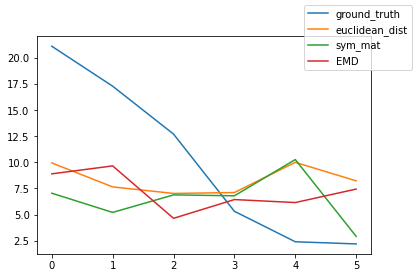

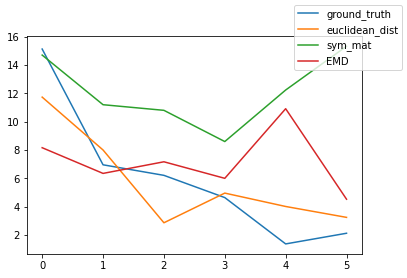

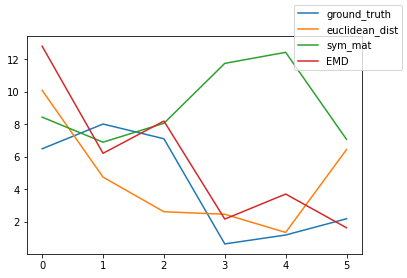

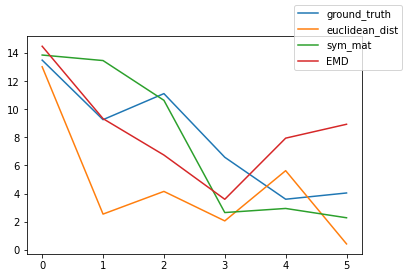

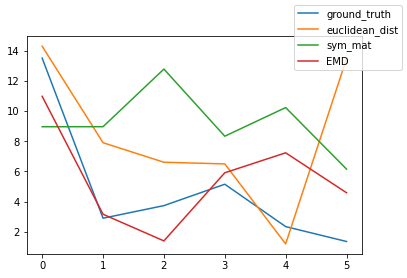

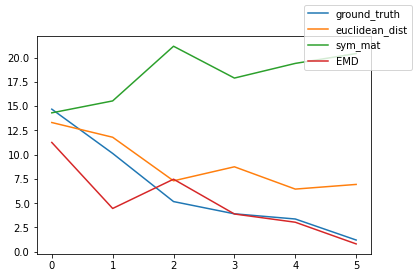

KeyboardInterrupt: 

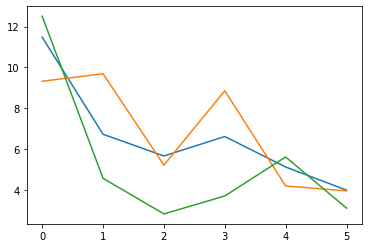

In [59]:
from head import TestShapeMatchBO
from scipy.spatial import distance
from scipy.stats import wasserstein_distance

# define metrics
def ground_truth(xi,yi,xt,yt, pi, pt):
    rdd = np.sqrt(np.sum((pi[:2]-pt[:2])**2))
    spd = 0 if pi[2]<0.5 else 1
    return -(rdd+spd)

def euclidean_dist(xi,yi,xt,yt, pi, pt):
    d = distance.euclidean(yi, yt)
    return -d

def sym_mat(xi,yi,xt,yt, pi, pt):
    M  = head.SymmetricMatrices(xt, yt,num_filters = 5)
    return -M.distance(yi)

def EMD(xi,yi,xt,yt, pi, pt):
    return -wasserstein_distance(yi, yt)

storage = {}
for epoch in range(10):
    fig, ax = plt.subplots()
    metrics = [ground_truth, euclidean_dist, sym_mat, EMD]
    for metric in metrics:
        expt = TestShapeMatchBO(metric)
        expt.run()
        plot_target_proximities(expt, ax=ax)
        ax.set_label(metric.__name__)
        storage[(epoch, metric.__name__)] = expt
    fig.legend([i.__name__ for i in metrics])
    plt.show()

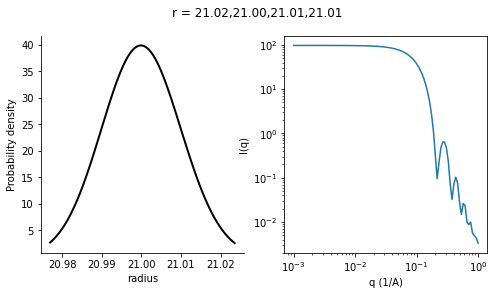

In [3]:
sim = head.EmulatorMultiShape()
sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)

fig, axs = plt.subplots(1,2,figsize=(4*2,4))

sim.plot_radii(axs[0])
axs[0].set_xlabel('radius')
axs[0].set_ylabel('Probability density')

if SPECTRA=='saxs':
    xt, yt = sim.get_saxs(shape_param = SHAPE_PARAM, n_samples=N_SAS_SAMPLES)
    axs[1].loglog(xt, yt)
    plt.setp(axs[1], xlabel='q (1/A)', ylabel='I(q)')
elif SPECTRA=='uvvis':
    xt, yt = sim.get_uvvis(shape_param = 0.67, n_samples=N_UVVIS_SAMPLES)
    axs[1].plot(xt, yt)
    plt.setp(axs[1], xlabel='wavelength (nm))', ylabel=r'I($\lambda$)')
    
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.radii))
plt.show()

In [4]:
# define search space
r_mu = [5,50]
r_sigma = [1e-4,1]
shape_param = [0,1]
bounds = torch.tensor((r_mu, r_sigma, shape_param)).T.to(**tkwargs)

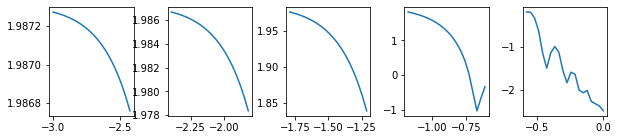

In [5]:
from head import SymmetricMatrices
if SPECTRA=='saxs':
    M = SymmetricMatrices(np.log10(xt), np.log10(yt) , 
                          num_filters = NUM_FILTERS)
else:
    M = SymmetricMatrices(xt, yt , 
                      num_filters = NUM_FILTERS)   
    
M.plot_filters()
def sym_dist(query):
    return -M.distance(query)

In [6]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()    
    sim.make_structure(r_mu=x_np[0],
                       r_sigma=x_np[1])
    if SPECTRA=='saxs':
        xi, yi = sim.get_saxs(shape_param = x_np[2], 
                              n_samples=N_SAS_SAMPLES)
        #dist = euclidean_dist(np.log10(yi),np.log10(yt))
        dist = sym_dist(np.log10(yi))
    elif SPECTRA=='uvvis':
        xi, yi = sim.get_uvvis(shape_param = x_np[2], 
                               n_samples=N_UVVIS_SAMPLES)
        #dist = euclidean_dist(yi,yt)
        dist = sym_dist(yi)
        
    expt[EXPT_ID] = [xi, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [7]:
from botorch.utils.sampling import draw_sobol_samples

def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj


train_x, train_obj = draw_random_batch(n_samples=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 8 samples randomly torch.Size([8, 3]) torch.Size([8, 1])
0	[28.02302271  0.23726575  0.72876054]	[-0.24564786]
1	[37.6677233   0.8934329   0.55607575]	[-0.3095354]
2	[16.32282734  0.87718958  0.8418383 ]	[-0.12904832]
3	[24.16555956  0.29978108  0.63338202]	[-0.31098095]
4	[32.28472829  0.20998077  0.65625972]	[-0.28078442]
5	[16.57979369  0.96406116  0.20941967]	[-0.11136201]
6	[39.76712584  0.4793711   0.46495205]	[-0.44214361]
7	[10.35346121  0.36028128  0.87811762]	[-0.12555783]


In [8]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [9]:
from botorch.optim.optimize import optimize_acqf

def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [10]:
torch.manual_seed(2021)
import pdb

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    #acquisition = qUpperConfidenceBound(model, beta=0.1)
    best_f = train_obj.max(axis=0).values
    acquisition = qExpectedImprovement(model, best_f = sym_dist(yt))
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

Sampled ID 	 Locations 	 Objectives
Iteration : 1/10
0	[16.64954473  1.          0.56053114]	[-0.19810866]
1	[43.61344311  0.34255941  0.4602909 ]	[-0.3649498]
2	[10.07816342  0.49410447  0.81700172]	[-0.13514009]
3	[35.52104914  0.03877661  0.12530367]	[-0.38836461]
4	[11.77536443  0.47593721  0.3163971 ]	[-0.18969023]
5	[16.48801173  0.70101821  0.41457636]	[-0.09994558]
6	[16.69929127  1.          0.        ]	[-0.11534668]
7	[16.2899261   1.          0.36049716]	[-0.1954342]
Iteration : 2/10
0	[10.06603843  0.20844415  1.        ]	[-0.13528202]
1	[21.69980892  1.          0.94426352]	[-0.25362199]
2	[10.34218233  0.42187717  0.4925186 ]	[-0.17380596]
3	[10.39043784  0.63098076  1.        ]	[-0.12277519]
4	[3.70873993e+01 9.99999975e-05 1.00000000e+00]	[-0.31728112]
5	[41.81379831  1.          0.        ]	[-0.41497239]
6	[16.61963291  0.75695449  0.12353399]	[-0.12663199]
7	[16.36258238  0.60539945  0.71372911]	[-0.1390493]
Iteration : 3/10
0	[4.10435345e+01 9.99999975e-05 1.00000000

In [11]:
# obtain best sample and corresponding objective
from botorch.acquisition import PosteriorMean

print('Actual target : ', [R_mu, R_sigma, SHAPE_PARAM])
opt_x, opt_obj = selector(PosteriorMean(model), q=1)
opt_x = opt_x.cpu().numpy().squeeze()
print('Optimal location: ',opt_x,
      '\nOptimal model scores: ', opt_obj.numpy())

Actual target :  [20, 0.01, 0.2]
Optimal location:  [12.71059606  0.24196702  0.8803833 ] 
Optimal model scores:  [[-0.10367491]]


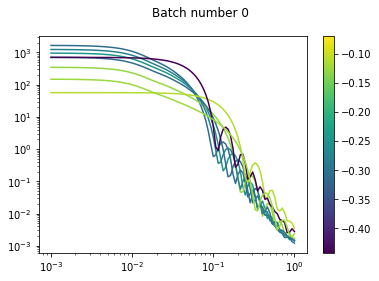

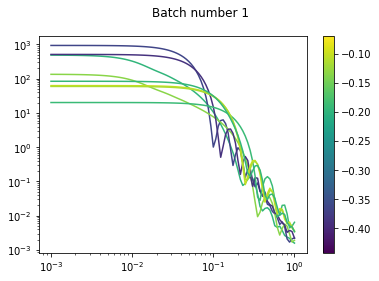

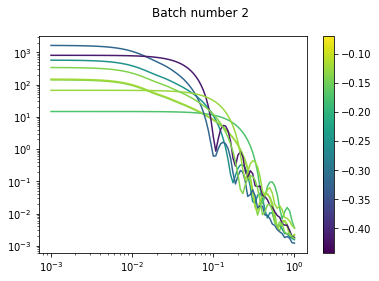

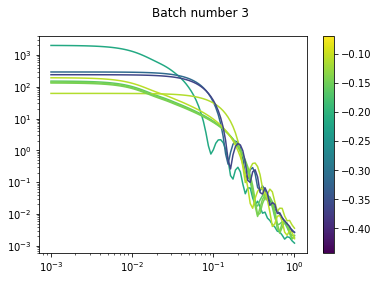

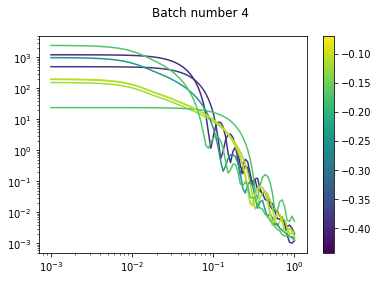

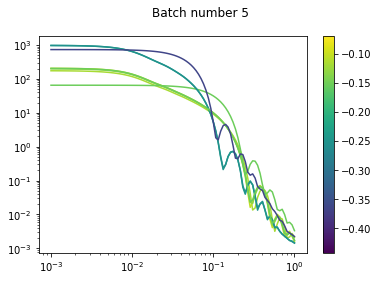

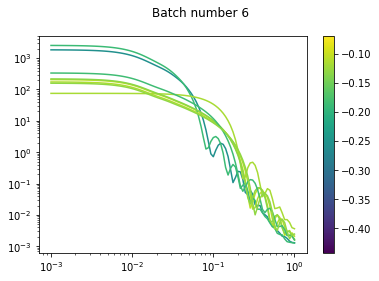

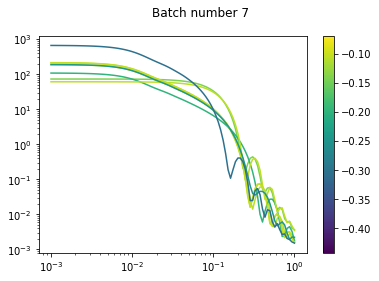

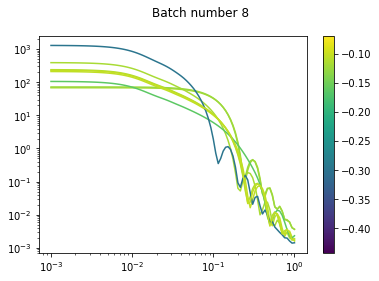

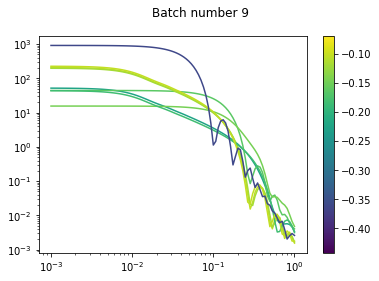

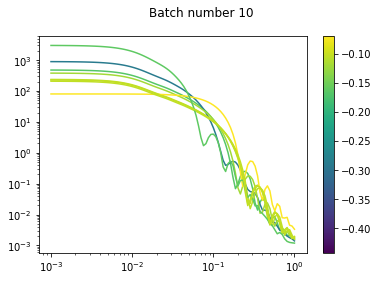

In [12]:
from matplotlib import cm
from matplotlib.colors import Normalize

all_scores = [v[2] for _, v in expt.items()]
norm = Normalize(vmin=min(all_scores), vmax=max(all_scores))
cmap = cm.get_cmap('viridis')
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

for b in np.unique(batch_number):
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Batch number %d'%b)
    for i in np.argwhere(batch_number==b).squeeze():
        if SPECTRA=='uvvis':
            ax.plot(expt[i][0], expt[i][1], 
                    color=cmap(norm(expt[i][2])))
        elif SPECTRA=='saxs':
            ax.loglog(expt[i][0], expt[i][1],
                      color=cmap(norm(expt[i][2])))
    cbar = fig.colorbar(mappable,ax=ax)
    plt.show()

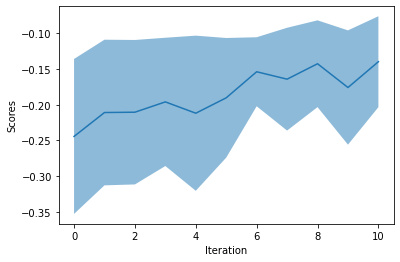

In [13]:
plot_scores = []
for b in np.unique(batch_number):
    scores = np.asarray(all_scores)[np.argwhere(batch_number==b)]
    mu, std = scores.mean(), scores.std()
    plot_scores.append([mu, mu+std, mu-std])
    
plot_scores = np.asarray(plot_scores)
fig, ax = plt.subplots()
ax.fill_between(np.unique(batch_number), y1=plot_scores[:,1], y2=plot_scores[:,2], alpha=0.5)
ax.plot(np.unique(batch_number), plot_scores[:,0])
ax.set_xlabel('Iteration')
ax.set_ylabel('Scores')
plt.show()